In [1]:
import preProcessing
import pandas as pd
from tqdm import tqdm

2022-06-09 09:57:28 INFO: Loading these models for language: hi (Hindi):
| Processor | Package |
-----------------------
| tokenize  | hdtb    |
| pos       | hdtb    |
| lemma     | hdtb    |

2022-06-09 09:57:28 INFO: Use device: cpu
2022-06-09 09:57:28 INFO: Loading: tokenize
2022-06-09 09:57:28 INFO: Loading: pos
2022-06-09 09:57:29 INFO: Loading: lemma
2022-06-09 09:57:29 INFO: Done loading processors!


In [2]:
df = pd.read_csv('lemmatized_news.csv')
df

,News,Label
0,नहीं वीडियो दिल्ली का सरकारी स्कूल मदरसा तब्दी...,0
1,मध्यप्रदेश शराब बिक्री शिवराज चौहान वीडियो फर्...,0
2,हिन्दू - मुस्लिम जोड़ हाई कोर्ट मिल सभ केस रद्...,1
3,अरुण लाल 66 उम्र शादी पूर्व क्रिकेटर वाला दुल्...,1
4,मध्यप्रदेश शराब बिक्री शिवराज चौहान वीडियो फर्...,0
...,...,...
4583,मुस्लिम पिता - पुत्री माँ - बेटा पुराना तस्वीर...,0
4584,चालक कार रोक का बजाय चल जार रख ट्रैफ़िक पुलिसक...,1
4585,हवा घुल ज़हरदिल्ली समेत उत्तर भारत का इलाका प्...,1
4586,वायरल वीडियो का लव जिहाद दावा फ़र्जी है“वीडियो ...,0


In [ ]:
""" df = preProcessing.eachNews(df)
df """

In [3]:
path = 'google/muril-base-cased'


from transformers import AutoModel, AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModel.from_pretrained(path,output_hidden_states=True)

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
embedds = []
for i in tqdm(df.index):
    temp = tokenizer.convert_ids_to_tokens(tokenizer.encode(df['News'][i]))
    input_encoded = tokenizer.encode_plus(df['News'][i], return_tensors="pt")
    with torch.no_grad():
        states = model(**input_encoded).hidden_states
    output = torch.stack([states[i] for i in range(len(states))])
    #output = output.squeeze()
    token_vecs = output[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    sentence_embedding = sentence_embedding.tolist()
    embedds.append(sentence_embedding)
    #print("Output shape is {}".format(output.shape))

100%|██████████| 4588/4588 [04:50<00:00, 15.81it/s]


In [5]:
import numpy as np
embedds = np.array(embedds)

In [6]:
embedds.shape

(4588, 768)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(embedds, np.array(df['Label'].tolist()), train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [8]:
X_train.shape

(3670, 768)

In [9]:
y_train.shape

(3670,)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import Model, Sequential
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
cnnModel = Sequential()
cnnModel.add(layers.LSTM(units=50, activation='relu', return_sequences=True, 
                input_shape=(X_train.shape[1], 1)))
cnnModel.add(layers.Dropout(0.2))

cnnModel.add(layers.Convolution1D(32, 4,activation='relu'))
cnnModel.add(layers.Dropout(0.3))

cnnModel.add(layers.AveragePooling1D())

cnnModel.add(layers.Convolution1D(64, 4,activation='relu'))
cnnModel.add(layers.Dropout(0.4))

cnnModel.add(layers.AveragePooling1D())

cnnModel.add(layers.Flatten())
cnnModel.add(layers.Dropout(0.6))

cnnModel.add(layers.Dense(units=1, activation='sigmoid'))

In [ ]:
cnnModel.summary()

In [ ]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
                    metrics=[tf.keras.metrics.BinaryAccuracy()])

checkpoint = ModelCheckpoint('modelCase.h5',verbose=1, monitor='val_binary_accuracy',save_best_only=True, mode='auto')

#checkpoint = ModelCheckpoint('model.h5',verbose=1, monitor='loss',save_best_only=True, mode='auto')


cnnModel.fit(x=X_train, y=y_train, batch_size=256, epochs=25, 
                validation_data=(X_test,y_test), callbacks=[checkpoint])

In [23]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import dill
from sklearn.metrics import confusion_matrix

SVM = svm.SVC(kernel='rbf', C=50, gamma='auto')
SVM.fit(X_train, y_train)

dill.dump(SVM, open('svmCase.sav', 'wb'))
pred = SVM.predict(X_rem)
print(f'SVM Accuracy: {accuracy_score(y_rem, pred)*100}%')

print(confusion_matrix(y_rem, pred))

SVM Accuracy: 99.23747276688452%
[[453   6]
 [  1 458]]


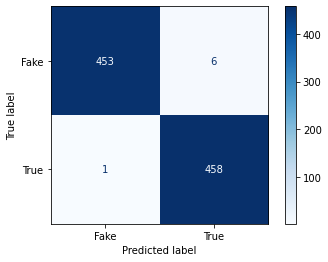

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_rem, pred), display_labels=['Fake', 'True'])
disp.plot(values_format='d', cmap='Blues')

In [25]:
from sklearn.metrics import roc_curve

pred = SVM.predict(X_rem).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_rem, pred)
print(fpr_keras)
print(tpr_keras)

[0.        0.0130719 1.       ]
[0.         0.99782135 1.        ]


In [26]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

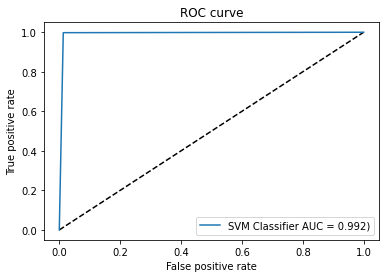

In [28]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='SVM Classifier AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import dill
from sklearn.metrics import accuracy_score

sc_x = StandardScaler()
xtrain = sc_x.fit_transform(X_train)
xtest = sc_x.transform(X_rem)

classifier = LogisticRegression(random_state = 0, max_iter=500)
classifier.fit(X_train, y_train)

dill.dump(classifier, open('logisticCase.sav', 'wb'))
y_pred = classifier.predict(X_rem)

print (f"Accuracy : {(accuracy_score(y_rem, y_pred)*100):.2f}%")